**Downloading and unzipping the dataset**

In [ ]:
!wget "https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip"

--2021-09-01 12:32:21--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2021-09-01 12:32:21--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uced63554b8a7312c3348d63cf6a.dl.dropboxusercontent.com/cd/0/inline/BVUumy5PtQ7QviK-X_BCt3lILT7CbpT1Ci-W4IDzxG4xEtMrgCWB13HfJ3UwMCprzeRukw_hogwySqWIl-2Y4LSU6aTB-LJIE0isx7VQsDIHpjqEElBlPeBaXTgd0igivKZLN-QXHA6L5cXZIEiI2twN/file# [following]
--2021-09-01 12:32:22--  https://uced63554b8a7312c3348d63cf6a.dl.dropboxusercontent.com/cd/0/inline/BVUumy5PtQ7QviK-X_BCt3lILT7CbpT1Ci-W4IDzxG4xEtMrgCWB13HfJ3UwMCprzeRukw_hogwySqWIl-2Y4LSU6aTB-

In [ ]:
## Unzipping the dataset
!unzip -q "/content/archive.zip"

**Preparation of the different dataset (train, validation, test)**

In [ ]:
## Importing all required libraries 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
## Creating the Pathlib Path objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test/")
test_path = Path("chest_xray/val/")

In [ ]:
## Collecting the paths inside "Normal" and "Pneumonia" of the above path
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

## Output is a Generate Object
print(train_image_paths)

<generator object Path.glob at 0x7f134ea51ad0>


In [ ]:
## Convert Generator Object in list of elements
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

## Now the output are 'PosixPath' object
print(train_image_paths[:10])

[PosixPath('chest_xray/train/NORMAL/IM-0741-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0551-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0543-0001-0002.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1142-0001-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0873-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0631-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0526-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0253-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0668-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0216-0001.jpeg')]


In [ ]:
## Convert PosixPath Objects to normal string 
train_image_paths = list(map(lambda x: str(x), train_image_paths))
val_image_paths = list(map(lambda x: str(x), val_image_paths))

print(train_image_paths[:5])

['chest_xray/train/NORMAL/IM-0741-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0551-0001.jpeg', 'chest_xray/train/NORMAL/IM-0543-0001-0002.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1142-0001-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0873-0001.jpeg']


In [ ]:
# Collect length for training and validation datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [ ]:
# Every image has label in its path, so let's get it
labels = {"NORMAL":0, "PNEUMONIA":1}
inv_labels = {0:"NORMAL", 1:"PNEUMONIA"}

def get_label(path : str) -> int:
  return labels[path.split("/")[-2]]

train_labels = list(map(lambda x: get_label(x), train_image_paths))
val_labels = list(map(lambda x: get_label(x), val_image_paths))

print(train_labels[:5])

[0, 0, 0, 0, 0]


In [ ]:
batch_size = 32

## Function used for transformation 
def load_transform(image, label, train = True):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [224, 224], method="nearest") ## 224 according to the research paper on ResNet50

  if train:
    image = tf.image.random_flip_left_right(image)

  return image, label 

In [ ]:
def get_dataset(paths, labels, train = True):
  image_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)

  dataset = dataset.map(lambda image, label: load_transform(image, label, train))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(2000)
  dataset = dataset.batch(batch_size)

  return dataset

In [ ]:
# creating training dataset
%time train_dataset = get_dataset(train_image_paths, train_labels)

image, label = next(iter(train_dataset))

print(image.shape)
print(label.shape)

CPU times: user 503 ms, sys: 365 ms, total: 868 ms
Wall time: 5.86 s
(32, 224, 224, 3)
(32,)


NORMAL


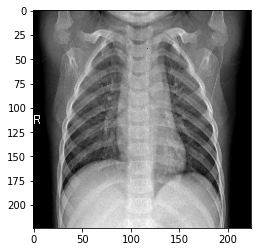

In [ ]:
## View a sample train image
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [ ]:
# creating validation dataset 
%time val_dataset = get_dataset(val_image_paths, val_labels, train=False)

image, label = next(iter(val_dataset))

print(image.shape)
print(label.shape)

CPU times: user 21 ms, sys: 1.07 ms, total: 22.1 ms
Wall time: 27.7 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


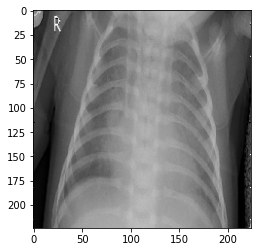

In [ ]:
## View a sample train image
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

**Modeling**

In [ ]:
# Building the CNN architecture --> ResNet50
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape = (224, 224, 3),
    include_top = False,
)

model = tf.keras.Sequential([
                             backbone,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
## Compiling the model 
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics = ["accuracy", tf.keras.metrics.Precision(name ="precision"), tf.keras.metrics.Recall(name="recall")]
)

## For multiclass problem loss must be: "categorical_crossentropy"

In [ ]:
## Defining callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

In [ ]:
val_dataset_length

624

In [ ]:
# Training the model
history = model.fit(
    train_dataset,
    steps_per_epoch = train_dataset_length//batch_size,
    epochs = 8,
    callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = val_dataset_length//batch_size,
)

Epoch 1/8
163/163 [==============================] - 209s 923ms/step - loss: 0.1285 - accuracy: 0.9509 - precision: 0.9647 - recall: 0.9614 - val_loss: 16.8230 - val_accuracy: 0.6217 - val_precision: 0.6211 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 16.82300, saving model to best_weights.h5
Epoch 2/8
163/163 [==============================] - 150s 922ms/step - loss: 0.0816 - accuracy: 0.9684 - precision: 0.9798 - recall: 0.9769 - val_loss: 0.6733 - val_accuracy: 0.8635 - val_precision: 0.9592 - val_recall: 0.8266

Epoch 00002: val_loss improved from 16.82300 to 0.67333, saving model to best_weights.h5
Epoch 3/8
163/163 [==============================] - 150s 922ms/step - loss: 0.0761 - accuracy: 0.9714 - precision: 0.9797 - recall: 0.9820 - val_loss: 1.7360 - val_accuracy: 0.7928 - val_precision: 0.7515 - val_recall: 0.9893

Epoch 00003: val_loss did not improve from 0.67333
Epoch 4/8
163/163 [==============================] - 151s 929ms/step - loss: 0.0550 - accu

In [ ]:
history.history

{'accuracy': [0.9509202241897583,
  0.9683665633201599,
  0.9714340567588806,
  0.9798696041107178,
  0.9812116622924805],
 'loss': [0.12849543988704681,
  0.08163612335920334,
  0.07611469179391861,
  0.055049341171979904,
  0.053872060030698776],
 'precision': [0.9647194743156433,
  0.9797581434249878,
  0.9797487854957581,
  0.9878238439559937,
  0.986838698387146],
 'recall': [0.9613832831382751,
  0.9769331812858582,
  0.9820144176483154,
  0.9850167632102966,
  0.9878584146499634],
 'val_accuracy': [0.6217105388641357,
  0.8634868264198303,
  0.7927631735801697,
  0.8371710777282715,
  0.6513158082962036],
 'val_loss': [16.822998046875,
  0.6733298301696777,
  1.7359695434570312,
  0.6834313869476318,
  4.995141506195068],
 'val_precision': [0.6210873126983643,
  0.9591836929321289,
  0.7515274882316589,
  0.8026315569877625,
  0.6513158082962036],
 'val_recall': [1.0,
  0.8266331553459167,
  0.989276111125946,
  0.9760000109672546,
  1.0]}

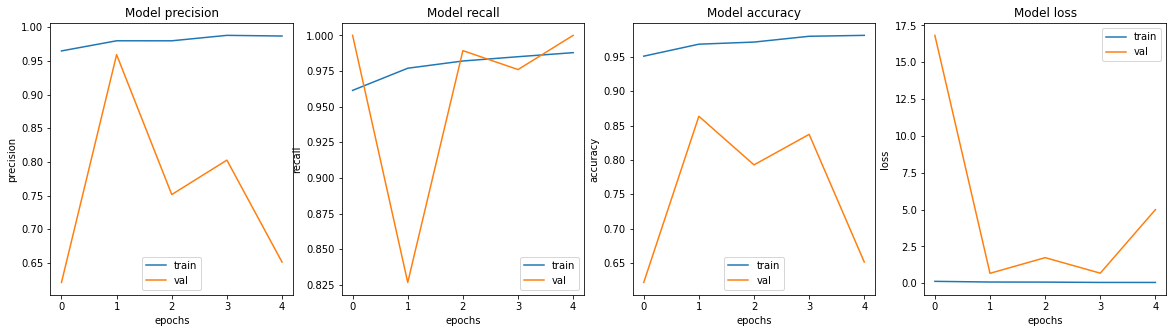

In [ ]:
# Interpreting the metrics 
fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history["val_" + met])
  ax[i].set_title("Model {}".format(met))
  ax[i].set_xlabel("epochs")
  ax[i].set_ylabel(met)
  ax[i].legend(["train", "val"])

**Saving and loading the model**

In [ ]:
# Saving the training model 


# loading the best weights
model.load_weights("/content/best_weights.h5")

# Saving the whole model (weights + Architecture)
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
## Loading the whole model
loaded_model = tf.keras.models.load_model("/content/model.h5")

**Evaluating the model on the test data**

In [ ]:
# Create a Sataset Object for 'Testing' set 
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x: str(x), test_image_paths))
test_labels = list(map(lambda x: get_label(x), test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224], method='nearest')

  return image, label

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels)).map(decode_image).batch(batch_size)
)

In [ ]:
## Verify test dataset Object
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


NORMAL


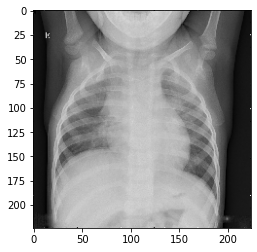

In [ ]:
## View a sample train image
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print("Testing accuracy :", acc)
print("Testing loss : ", loss)
print("Testing precision : ", prec)
print("Testing recall :", rec)

1/1 [==============================] - 2s 2s/step - loss: 0.6047 - accuracy: 0.7500 - precision: 1.0000 - recall: 0.5000
Testing accuracy : 0.75
Testing loss :  0.6047252416610718
Testing precision :  1.0
Testing recall : 0.5
